<a href="https://colab.research.google.com/github/Pillangocska/Machine_Learning_VIMIMA05/blob/main/4_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variációs autoenkóder

A gyakorlaton MNIST képekre fogunk generatív modelleket építeni.

**1. feladat.** Az alábbi két blokk futtatásával töltsd be az adatokat. A skálázás és a minibatch-méret szabadon változtatható.

In [1]:
%pylab inline

import torch
from torchvision import datasets


Populating the interactive namespace from numpy and matplotlib


In [2]:
train = datasets.MNIST('./data',train=True,download=True)
test  = datasets.MNIST('./data',train=False,download=True)
# data
x     = train.data
# labels
x_cl  = train.targets
x_t   = test.data
x_tcl = test.targets

# scale and reshape for conv network
x = (x / 255.0).view(-1, 1, 28, 28)  # scale [0, 1]
x_t = (x_t / 255.0).view(-1, 1, 28, 28)  # scale [0, 1]

# dataset and loader for minibatch processing
dataset = torch.utils.data.TensorDataset(x,x_cl)
loader  = torch.utils.data.DataLoader(dataset,batch_size=256,shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 162266941.61it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41160616.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49990540.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23289154.97it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**2. feladat.** Rajzolj ki egy véletlenszerűen választott képet!

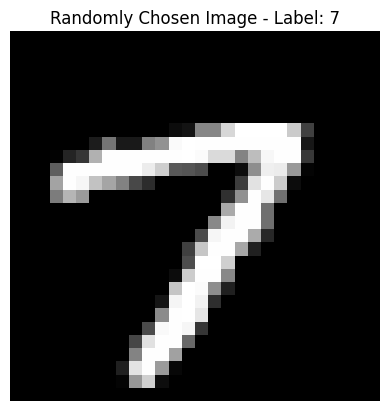

In [3]:
import matplotlib.pyplot as plt
import numpy as np

random_idx = np.random.randint(0, len(x))
random_image = x[random_idx].squeeze()

plt.imshow(random_image, cmap='gray')
plt.title(f"Randomly Chosen Image - Label: {x_cl[random_idx]}")
plt.axis('off')
plt.show()


**2. feladat.** A `VAE` osztályban valósítsd meg a következőket:

- Hozd létre az enkóder hálózatot, amelynek bemenete a kép, kimenete a látens reprezentáció várható értéke és szórása. A hálózat architektúrája tetszőleges (célszerű konvolúciós rétegeket is használni).
- Hozd létre a dekóder hálózatot, amelynek bemenete a látens változóból vett minta, kimenete pedig a rekonstruált kép (célszerű `ConvTranspose2d` típusú rétegeket is használni).
- Valósítsd meg a kódoló és dekódoló függvényeket (`encode`, `decode`).

In [4]:
from torch import nn
from torch.nn import functional as F

class VAE(torch.nn.Module):
  """
  Variational autoencoder

  Input:
  L -- latent variable dimension
  """
  def __init__(self,L):
    super(VAE, self).__init__()
    self.L   = L

    # Encoder
    self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
    self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
    self.enc_fc1 = nn.Linear(32 * 7 * 7, 128)
    self.enc_fc2_mean = nn.Linear(128, L)
    self.enc_fc2_logvar = nn.Linear(128, L)
    # Decoder
    self.dec_fc1 = nn.Linear(L, 128)
    self.dec_fc2 = nn.Linear(128, 32 * 7 * 7)
    self.dec_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.dec_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

  """
  Encoder function (image -> latent)

  Input:
  x -- image

  Output:
  mu -- latent representation expected value
  lv -- logarithm of latent representation variant
  """
  def encode(self, x):
    x = F.relu(self.enc_conv1(x))
    x = F.relu(self.enc_conv2(x))
    x = x.view(-1, 32 * 7 * 7)
    x = F.relu(self.enc_fc1(x))
    return self.enc_fc2_mean(x), self.enc_fc2_logvar(x)

  """
  Decoder function (latent sample -> image)

  Input:
  z -- a sample taken from a latent variable

  Output:
  x -- reconstructed image
  """
  def decode(self, z):
    x = F.relu(self.dec_fc1(z))
    x = F.relu(self.dec_fc2(x))
    x = x.view(-1, 32, 7, 7)
    x = F.relu(self.dec_conv1(x))
    x = torch.sigmoid(self.dec_conv2(x))
    return x

  """
  Forward pass in one piece:

  1. Encode (image -> latent)
  2. Sampling (latent -> latent sample)
  3. Decode (latent sample -> image)
  """
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar


**3. feladat.** Implementáld a KL-divergenciát és rekonstrukciós loss-t tartalmazó veszteségfüggvényt, majd tanítsd a hálózatot.

- Rekonstrukciós hiba $x$ kép és $\hat x$ rekonstrukció esetén: $$\left\| x - \hat x \right\|^2,$$
- KL-divergencia (a $\mu$, $\sigma^2$ paraméterű látens eloszlás és a $0$ várható értékű, egységmátrix kovarianciájú normális eloszlású prior között): $$\frac{1}{2} \left(\mu^2 + \sigma^2 - 1 - \log\sigma^2 \right),$$
- Veszteségfüggvény: az előbbiek összege (rekonstrukciós hiba + KL-divergencia).

In [5]:
import torch.optim as optim

model = VAE(2).cuda() # move the model to the gpu
optimizer = optim.Adam(model.parameters())


In [7]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (x_batch, _) in enumerate(loader):
        x_batch = x_batch.cuda()  # move the batch to GPU
        optimizer.zero_grad()  # zero the gradients

        # forward pass
        x_recon, mu, logvar = model(x_batch)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_recon, x_batch, reduction='sum')

        # KL divergence
        epsilon = 1e-7 # small constant
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - (logvar.exp() + epsilon))

        # total loss
        loss = recon_loss + kl_div

        # backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/100], Loss: 230.7836
Epoch [2/100], Loss: 176.5101
Epoch [3/100], Loss: 165.7022
Epoch [4/100], Loss: 161.3805
Epoch [5/100], Loss: 158.9970
Epoch [6/100], Loss: 157.3599
Epoch [7/100], Loss: 156.2140
Epoch [8/100], Loss: 155.2621
Epoch [9/100], Loss: 154.4204
Epoch [10/100], Loss: 153.8735
Epoch [11/100], Loss: 153.3106
Epoch [12/100], Loss: 152.8254
Epoch [13/100], Loss: 152.2529
Epoch [14/100], Loss: 151.8703
Epoch [15/100], Loss: 151.5838
Epoch [16/100], Loss: 151.1766
Epoch [17/100], Loss: 150.9343
Epoch [18/100], Loss: 150.6712
Epoch [19/100], Loss: 150.3798
Epoch [20/100], Loss: 150.0983
Epoch [21/100], Loss: 149.9552
Epoch [22/100], Loss: 149.6768
Epoch [23/100], Loss: 149.6270
Epoch [24/100], Loss: 149.3174
Epoch [25/100], Loss: 149.1184
Epoch [26/100], Loss: 148.9594
Epoch [27/100], Loss: 148.8176
Epoch [28/100], Loss: 148.6115
Epoch [29/100], Loss: 148.5529
Epoch [30/100], Loss: 148.3832
Epoch [31/100], Loss: 148.2150
Epoch [32/100], Loss: 148.0887
Epoch [33/100], L

**4. feladat.** Vizsgáld meg a tanított hálózat generatív teljesítményét.

- Generálj képeket úgy, hogy a modellnek csak a generatív oldalát használod, a látens eloszlásból vett mintákra, mint bemenetre. Sikeres volt a tanítás, számjegyek jelennek meg a kimeneten?
- Vizsgáld meg a rekonstrukciókat a tanítóhalmazból véletlenszerűen választott minták segítségével (a teljes hálózat mennyire tudja rekonstruálni ezeket a mintákat).
- Vizsgáld meg a látens reprezentációkat. Klasztereződnek ezek aszerint, hogy a bemenet milyen számot ábrázol?

**Szorgalmi.** Módosítsd a architektúrát úgy, hogy javuljon a rekonstrukció és a generált minták minősége!

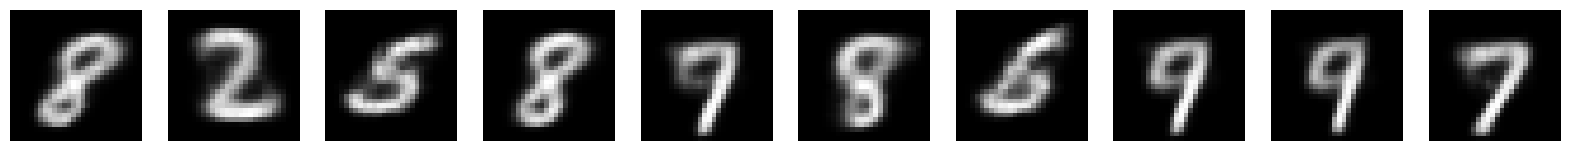

In [8]:
def generate_images(model, num_images=10):
    with torch.no_grad():
        model.eval()
        # sample random points from the latent space
        z = torch.randn(num_images, model.L).cuda()
        # generate images from the sampled points
        generated_images = model.decode(z)
    return generated_images

# generate images and visualize them
generated_images = generate_images(model)
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()


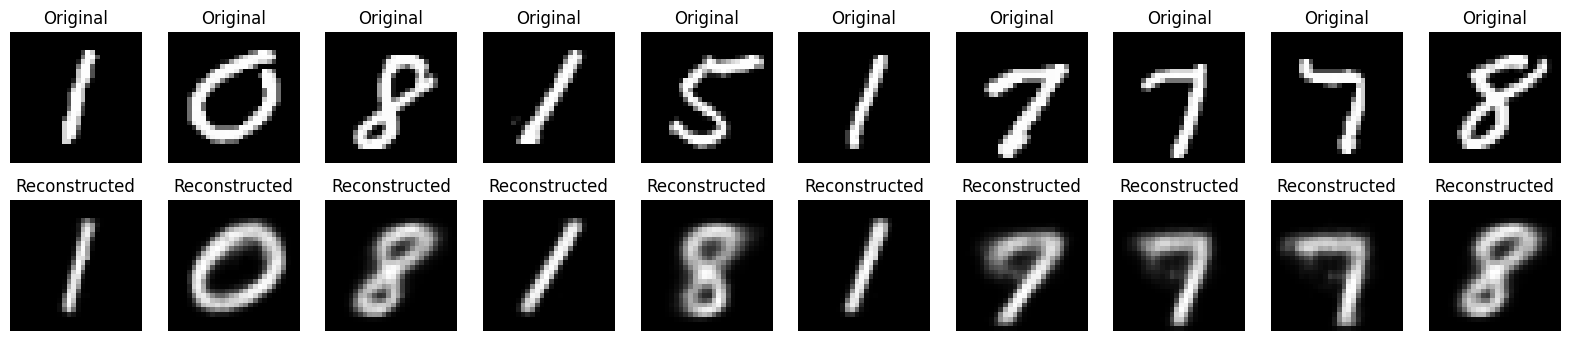

In [9]:
def visualize_reconstructions(model, data_loader, num_images=10):
    with torch.no_grad():
        model.eval()
        x, _ = next(iter(data_loader))
        x = x[:num_images].cuda()
        recon, _, _ = model(x)

        fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
        for i in range(num_images):
            axes[0, i].imshow(x[i].cpu().squeeze().numpy(), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(recon[i].cpu().squeeze().numpy(), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
    plt.show()

visualize_reconstructions(model, loader)


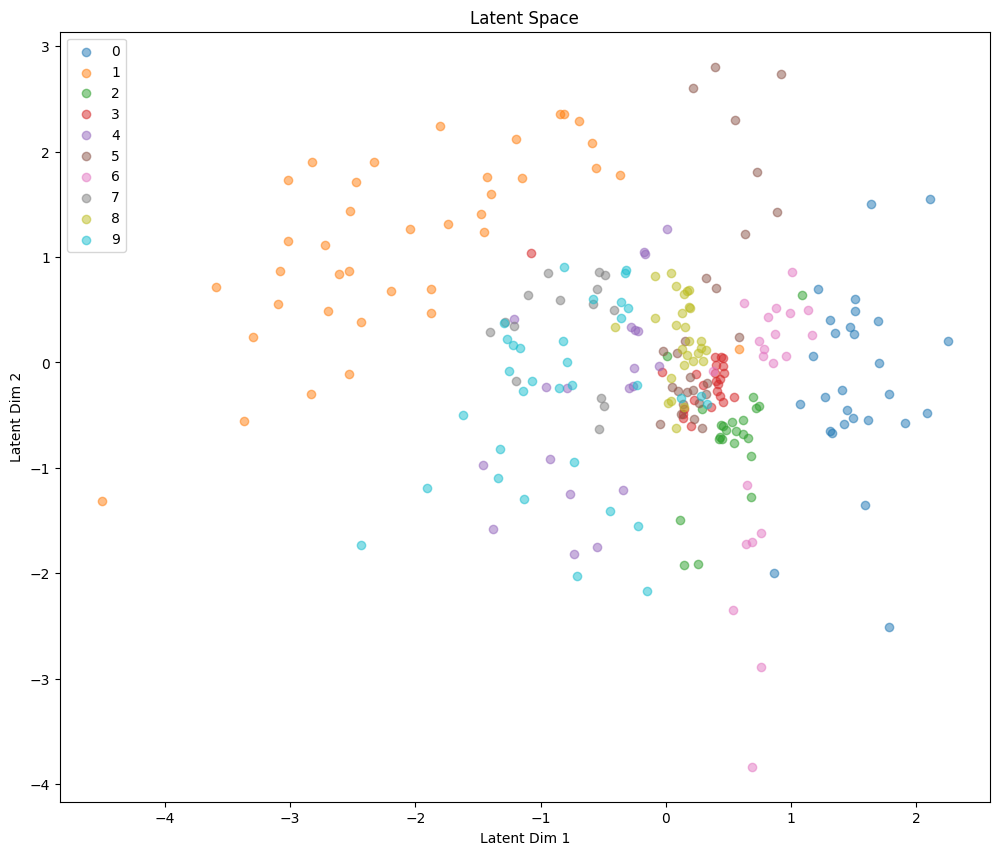

In [18]:
def visualize_latent_space(model, data_loader, num_points=1000):
    with torch.no_grad():
        model.eval()
        x, y = next(iter(data_loader))
        x, y = x[:num_points].cuda(), y[:num_points]
        mu, _ = model.encode(x)

        plt.figure(figsize=(12, 10))
        for i in range(10):
            indices = y == i
            plt.scatter(mu[indices, 0].cpu(), mu[indices, 1].cpu(), label=str(i), alpha=0.5)
        plt.legend()
        plt.xlabel("Latent Dim 1")
        plt.ylabel("Latent Dim 2")
        plt.title("Latent Space")
    plt.show()

visualize_latent_space(model, loader)
